In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set_style('white')

%matplotlib inline

In [2]:
import pymc3

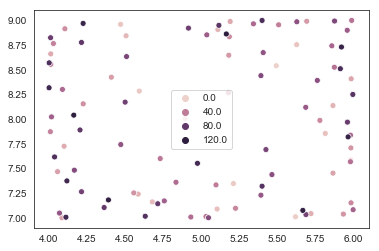

In [3]:
np.random.seed(1)

space = np.linspace(1, 100, 100)
X = 5 + np.sin(space + np.random.randn(len(space)))
Y = 8 + np.cos(space)

sns.scatterplot(X, Y, hue=space);

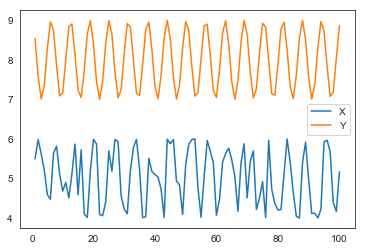

In [4]:
sns.lineplot(space, X, label='X');
sns.lineplot(space, Y, label='Y');
plt.legend(loc='best');

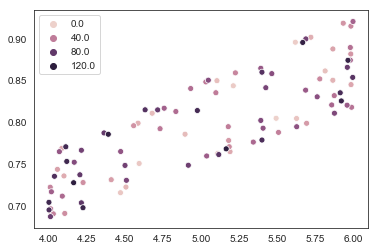

In [5]:
def convert(X, Y):
    return np.exp((X - Y) / (X + Y))

def invert(X, Y):
    return X * (1 - np.log(Y)) / (1 + np.log(Y))

Y_converted = convert(X, Y)
sns.scatterplot(X, Y_converted, hue=space);

In [6]:
model = pymc3.Model()

with model:
    alpha = pymc3.Normal('alpha', mu=1, sd=1)
    gamma = pymc3.Normal('gamma', mu=1, sd=1)
    
    regression = alpha + gamma * X
    
    sigma = pymc3.HalfNormal('sigma', sd=1e-3)
    observed = pymc3.Normal(
        'observed',
        mu=regression,
        sd=sigma,
        observed=Y_converted
    )

In [7]:
MAP = pymc3.find_MAP(model=model)
MAP

logp = -21.193, ||grad|| = 0.0012635: 100%|██████████| 42/42 [00:00<00:00, 480.64it/s]   


{'alpha': array(0.43171776),
 'gamma': array(0.07276005),
 'sigma': array(0.01705024),
 'sigma_log__': array(-4.07159098)}

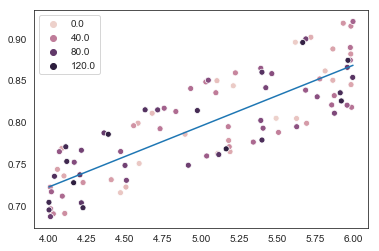

In [8]:
sns.scatterplot(X, Y_converted, hue=space);
sns.lineplot(X, MAP['alpha'] + X * MAP['gamma']);

In [9]:
with model:
    trace = pymc3.sample(cores=1, tune=100, samples=100, start=MAP)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, gamma, alpha]
100%|██████████| 600/600 [00:09<00:00, 60.40it/s]
The acceptance probability does not match the target. It is 0.9541743387605375, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9601774450826106, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


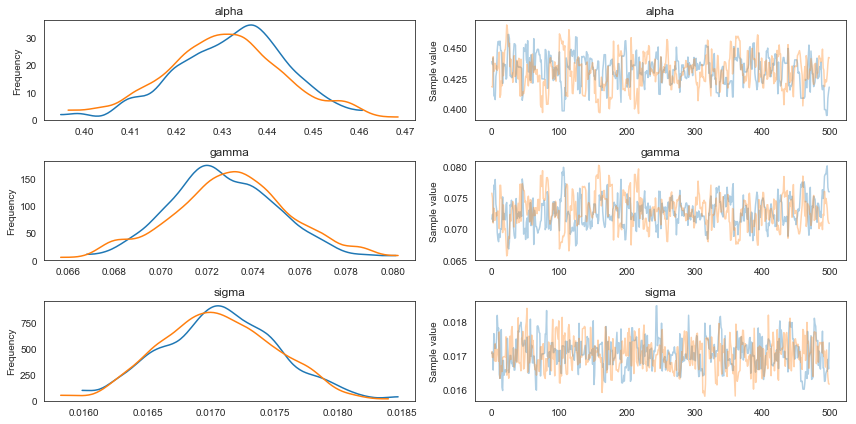

In [10]:
pymc3.traceplot(trace);

In [11]:
ppc = pymc3.sample_ppc(trace, model=model, samples=100)

100%|██████████| 100/100 [00:00<00:00, 227.54it/s]


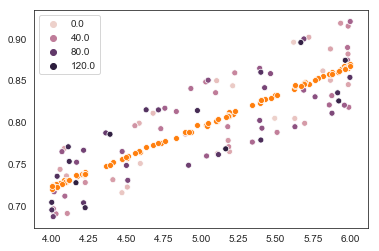

In [12]:
sns.scatterplot(X, Y_converted, hue=space);
sns.scatterplot(X, ppc['observed'].mean(axis=0));

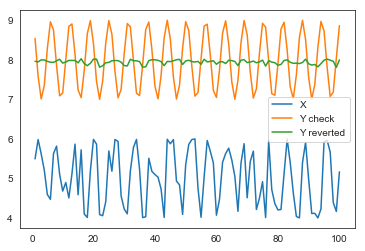

In [13]:
Y_reverted = invert(X, ppc['observed'].mean(axis=0))

sns.lineplot(space, X, label='X');
sns.lineplot(space, invert(X, Y_converted), label='Y check')
sns.lineplot(space, Y_reverted, label='Y reverted');
plt.legend(loc='best');